<p style="align: center;"><img src="https://static.tildacdn.com/tild6636-3531-4239-b465-376364646465/Deep_Learning_School.png" width="400"></p>

# Глубокое обучение. Часть 2
# Домашнее задание по теме "Механизм внимания"

Это домашнее задание проходит в формате peer-review. Это означает, что его будут проверять ваши однокурсники. Поэтому пишите разборчивый код, добавляйте комментарии и пишите выводы после проделанной работы.

В этом задании вы будете решать задачу классификации математических задач по темам (многоклассовая классификация) с помощью Transformer.

В качестве датасета возьмем датасет математических задач по разным темам. Нам необходим следующий файл:

[Файл с классами](https://docs.google.com/spreadsheets/d/13YIbphbWc62sfa-bCh8MLQWKizaXbQK9/edit?usp=drive_link&ouid=104379615679964018037&rtpof=true&sd=true)

**Hint:** не перезаписывайте модели, которые вы получите на каждом из этапов этого дз. Они ещё понадобятся.

### Задание 1 (2 балла)

Напишите кастомный класс для модели трансформера для задачи классификации, использующей в качествке backbone какую-то из моделей huggingface.

Т.е. конструктор класса должен принимать на вход название модели и подгружать её из huggingface, а затем использовать в качестве backbone (достаточно возможности использовать в качестве backbone те модели, которые упомянуты в последующих пунктах)

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel
from typing import Union, Dict, Optional
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from tqdm import tqdm
import pandas as pd
import numpy as np
import copy
from torch.optim import AdamW
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int):
        super().__init__()
        
        if isinstance(base_transformer_model, str):
            self.backbone = AutoModel.from_pretrained(base_transformer_model)
        else:
            self.backbone = base_transformer_model
        
        if hasattr(self.backbone, 'config'):
            hidden_size = self.backbone.config.hidden_size
        else:
            hidden_size = 768  
    
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(hidden_size, num_classes)
        
    def forward(self, 
                input_ids: torch.Tensor,
                attention_mask: Optional[torch.Tensor] = None,
                token_type_ids: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        
        backbone_outputs = self.backbone(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True
        )
        pooled_output = backbone_outputs.last_hidden_state[:, 0, :]
        
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
    
        return {'logits': logits}

### Задание 2 (1 балл)

Напишите функцию заморозки backbone у модели (если необходимо, возвращайте из функции модель)

In [2]:
def freeze_backbone(model: TransformerClassificationModel, 
                   freeze: bool = True) -> TransformerClassificationModel:
                   
    for param in model.backbone.parameters():
        param.requires_grad = not freeze


    for param in model.classifier.parameters():
        param.requires_grad = True
    
    print(f"Backbone {'заморожен' if freeze else 'разморожен'}")
    print(f"Classifier разморожен")
    
    return model

### Задание 3 (2 балла)

Напишите функцию, которая будет использована для тренировки (дообучения) трансформера (TransformerClassificationModel). Функция должна поддерживать обучение с замороженным и размороженным backbone.

In [ ]:
def train_transformer(transformer_model, train_loader, freeze_backbone=True, num_epochs=3):
    model = copy.deepcopy(transformer_model)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    for param in model.backbone.parameters():
        param.requires_grad = not freeze_backbone
    
    optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)
    criterion = nn.CrossEntropyLoss()
    
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs['logits'], labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}')
    
    return model

### Задание 4 (1 балл)

Проверьте вашу функцию из предыдущего пункта, дообучив двумя способами
*cointegrated/rubert-tiny2* из huggingface.

In [4]:
class MathProblemsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

df = pd.read_excel('data_problems_translated.xlsx')

unique_topics = np.array(['number_theory', 'polynoms', 'combinatorics', 'graphs', 'geometry', 'invariant', 'dirichlet'])
topic_to_label = {topic: i for i, topic in enumerate(unique_topics)}

texts = df['problem_text'].tolist()
labels = [topic_to_label[topic] for topic in df['topic']]

tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

dataset = MathProblemsDataset(texts, labels, tokenizer)
train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [5]:
rubert_tiny_transformer_model = TransformerClassificationModel(
    base_transformer_model="cointegrated/rubert-tiny2",
    num_classes=7
)

rubert_tiny_finetuned_with_freezed_backbone = train_transformer(
    rubert_tiny_transformer_model, 
    train_loader=train_loader, 
    freeze_backbone=True,
    num_epochs=3
)

rubert_tiny_transformer_model = TransformerClassificationModel(
    base_transformer_model="cointegrated/rubert-tiny2",
    num_classes=7
)

rubert_tiny_full_finetuned = train_transformer(
    rubert_tiny_transformer_model,
    train_loader=train_loader,
    freeze_backbone=False,
    num_epochs=3
)

100%|██████████| 660/660 [01:54<00:00,  5.76it/s]


Epoch 1, Loss: 1.7615


100%|██████████| 660/660 [01:52<00:00,  5.86it/s]


Epoch 2, Loss: 1.6016


100%|██████████| 660/660 [01:56<00:00,  5.67it/s]


Epoch 3, Loss: 1.5357


100%|██████████| 660/660 [04:31<00:00,  2.43it/s]


Epoch 1, Loss: 1.2610


100%|██████████| 660/660 [04:34<00:00,  2.40it/s]


Epoch 2, Loss: 1.0015


100%|██████████| 660/660 [04:29<00:00,  2.45it/s]

Epoch 3, Loss: 0.8955


### Задание 5 (1 балл)

Обучите *tbs17/MathBert* (с замороженным backbone и без заморозки), проанализируйте результаты. Сравните скоры с первым заданием. Получилось лучше или нет? Почему?

Тут модель не загрузилась

### Задание 6 (1 балл)

Напишите функцию для отрисовки карт внимания первого слоя для моделей из задания

In [38]:
def draw_first_layer_attention_maps(attention_head_ids, text: str, model: TransformerClassificationModel):
    tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    
    model.eval()

    with torch.no_grad():
        outputs = model.backbone(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            output_attentions=True,  
            return_dict=True
        )
    
    first_layer_attention = outputs.attentions[0][0]  
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    num_heads = len(attention_head_ids)
    fig, axes = plt.subplots(1, num_heads, figsize=(5 * num_heads + 10, 8))
    
    if num_heads == 1:
        axes = [axes]
    
    for i, head_id in enumerate(attention_head_ids):
        if head_id >= first_layer_attention.size(0):
            print(f"Внимание: голова {head_id} не существует. Максимальный индекс: {first_layer_attention.size(0)-1}")
            continue
            
        attention_weights = first_layer_attention[head_id].cpu().numpy()
        
        sns.heatmap(
            attention_weights,
            xticklabels=tokens,
            yticklabels=tokens,
            cmap="viridis",
            ax=axes[i],
            cbar_kws={'shrink': 0.8}
        )
        axes[i].set_title(f'Голова внимания {head_id}')
        axes[i].set_xlabel('Токены (куда)')
        axes[i].set_ylabel('Токены (откуда)')
        axes[i].tick_params(axis='x', rotation=90)
        axes[i].tick_params(axis='y', rotation=0)
    
    plt.suptitle(f'Карты внимания первого слоя для текста: "{text[:50]}..."', fontsize=14)
    plt.tight_layout()
    plt.show()


### Задание 7 (1 балл)

Проведите инференс для всех моделей **ДО ДООБУЧЕНИЯ** на 2-3 текстах из датасета. Посмотрите на головы Attention первого слоя в каждой модели на выбранных текстах (отрисуйте их отдельно).

Попробуйте их проинтерпретировать. Какие связи улавливают карты внимания? (если в модели много голов Attention, то проинтерпретируйте наиболее интересные)

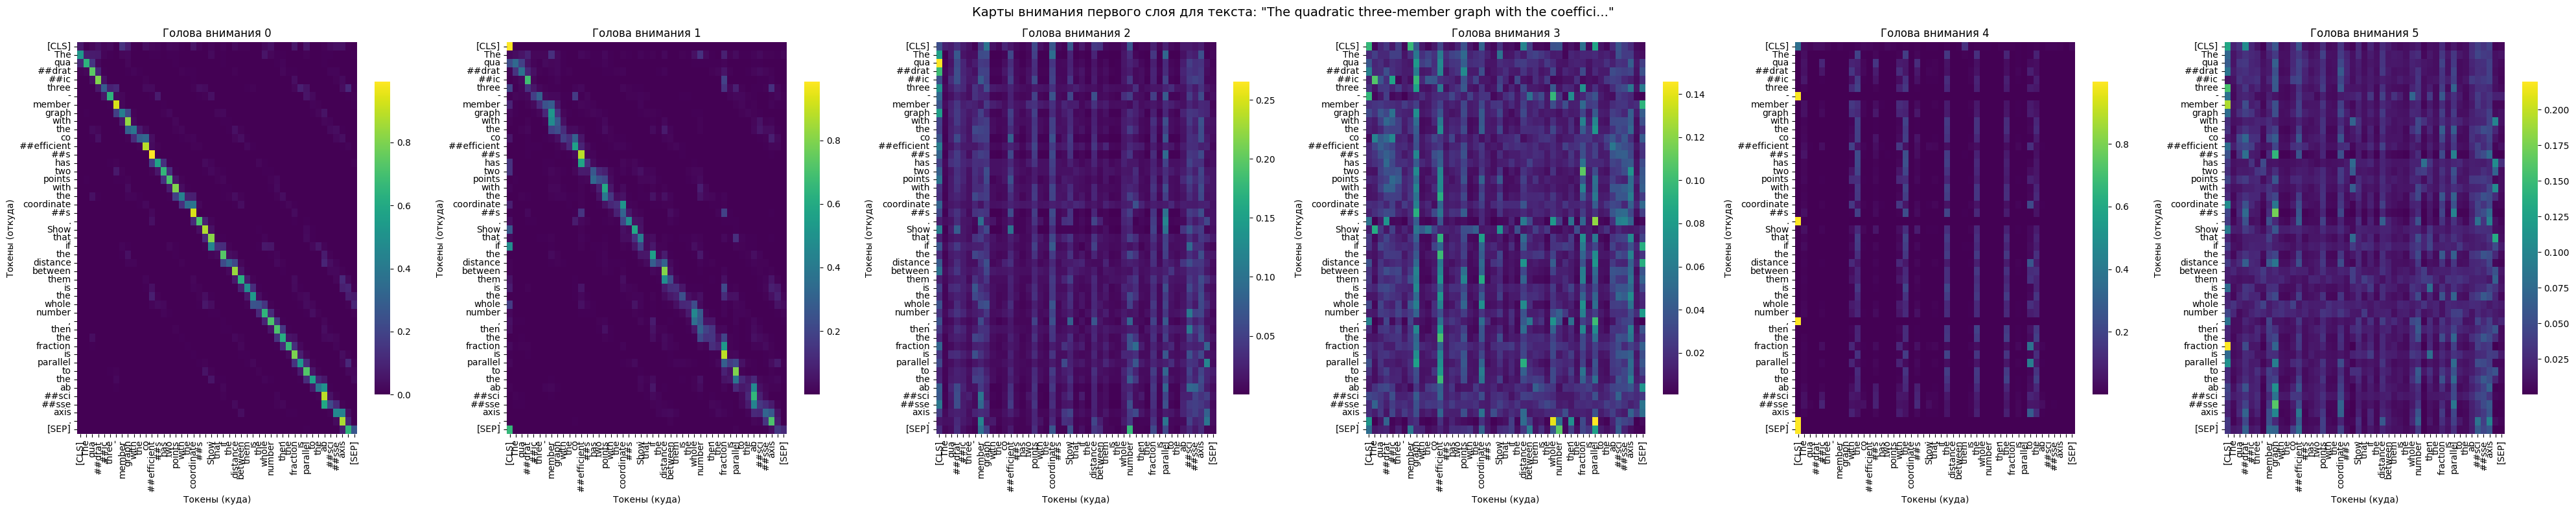

In [39]:
draw_first_layer_attention_maps([0, 1, 2, 3,4,5], "The quadratic three-member graph with the coefficients has two points with the coordinates. Show that if the distance between them is the whole number, then the fraction is parallel to the abscisse axis.", rubert_tiny_finetuned_with_freezed_backbone)

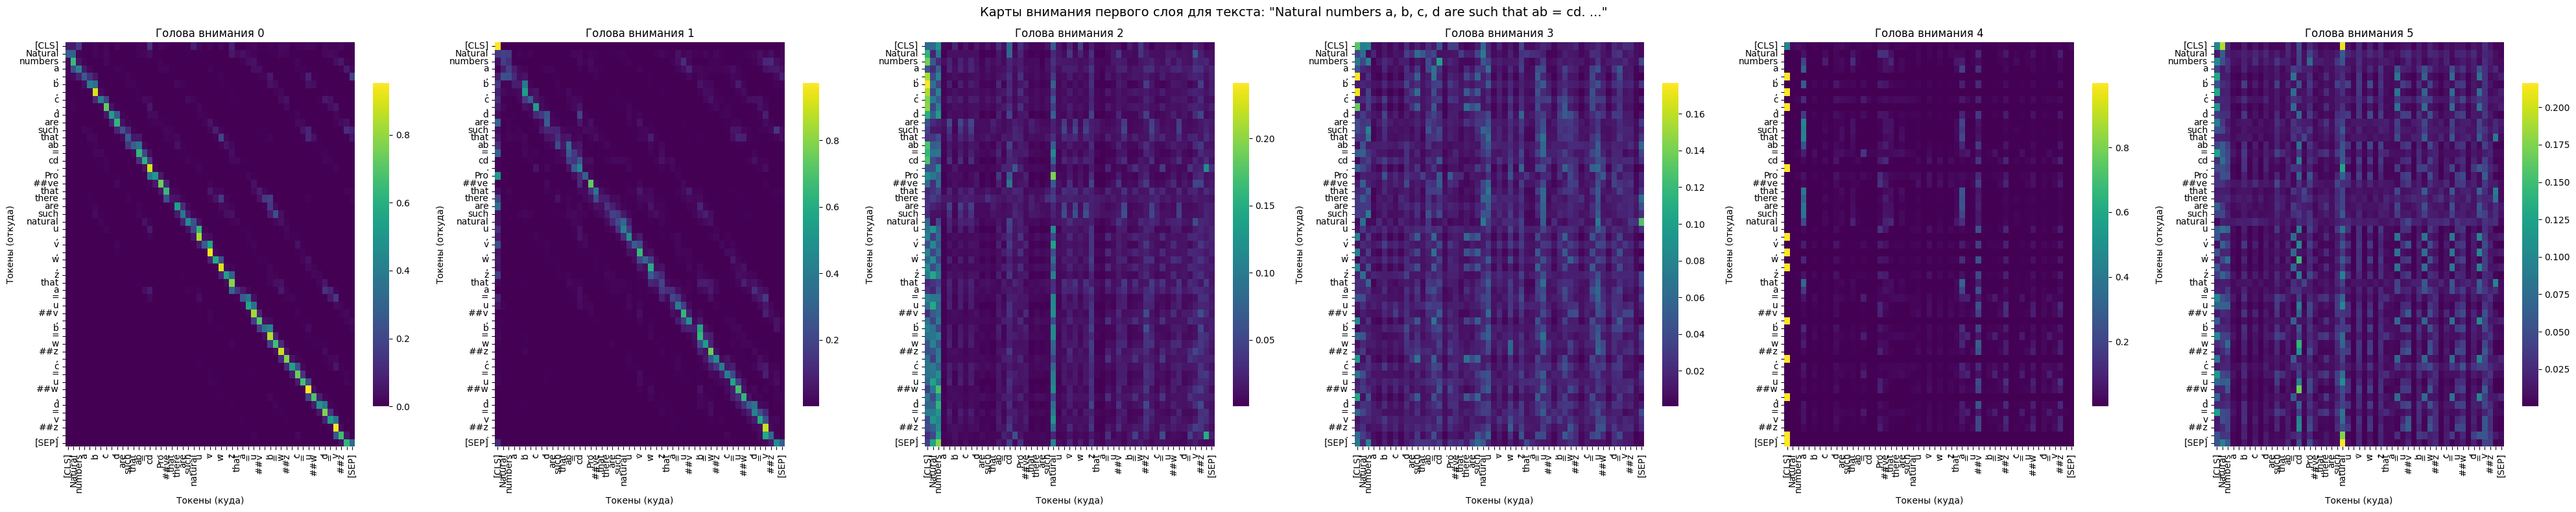

In [41]:
draw_first_layer_attention_maps([0, 1, 2, 3,4,5], 'Natural numbers a, b, c, d are such that ab = cd. Prove that there are such natural u, v, w, z that a = uv, b = wz, c = uw, d = vz.' ,rubert_tiny_finetuned_with_freezed_backbone)

### Задание 8 (1 балл)

Сделайте то же самое для дообученных моделей. Изменились ли карты внимания и связи, которые они улавливают? Почему?

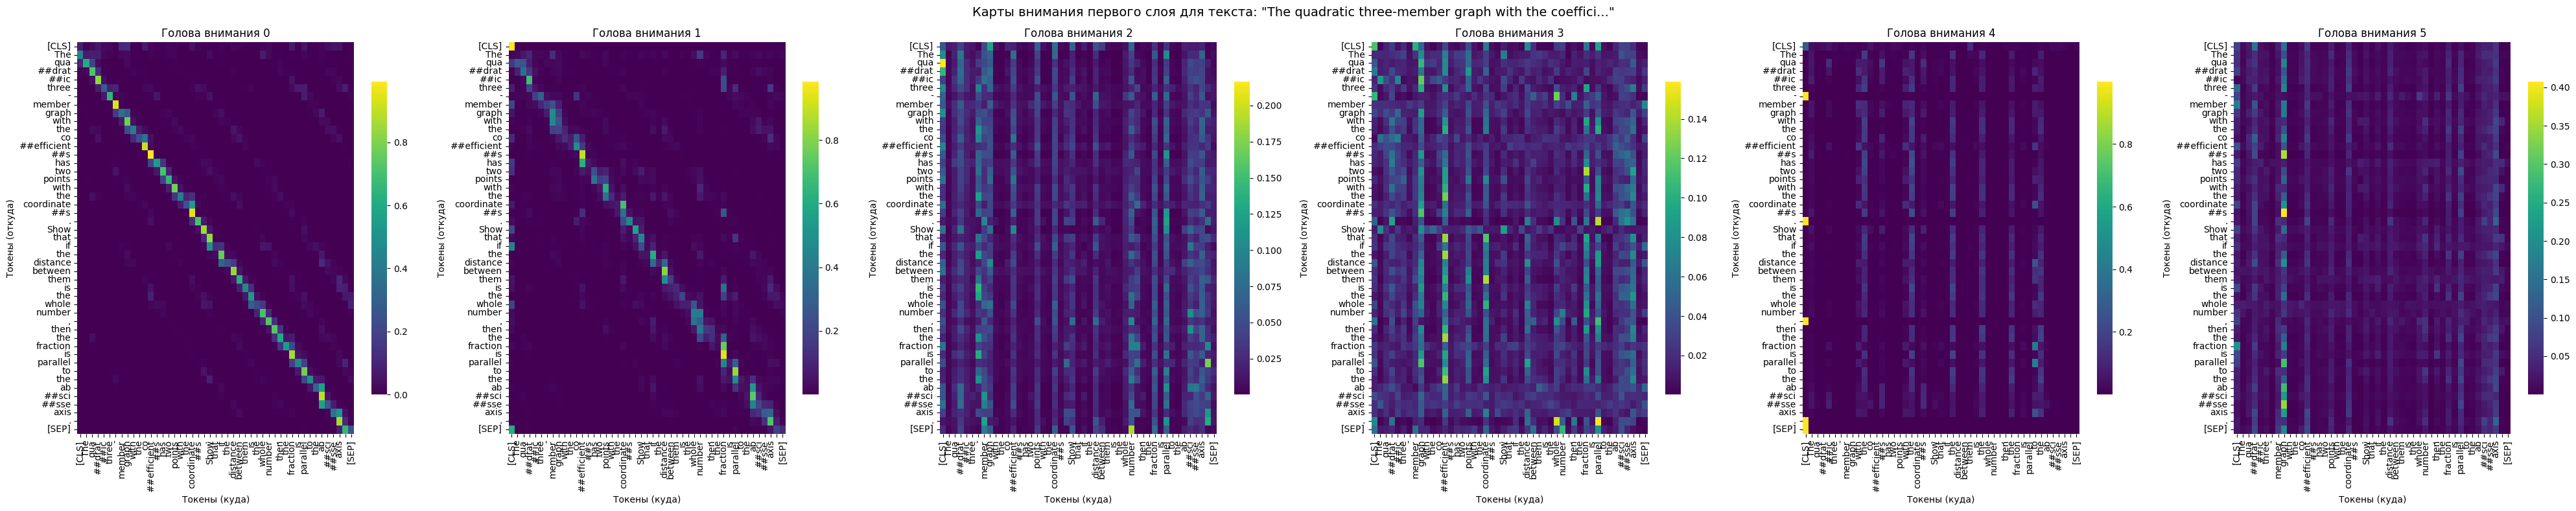

In [42]:
draw_first_layer_attention_maps([0, 1, 2, 3,4,5], "The quadratic three-member graph with the coefficients has two points with the coordinates. Show that if the distance between them is the whole number, then the fraction is parallel to the abscisse axis.", rubert_tiny_full_finetuned)

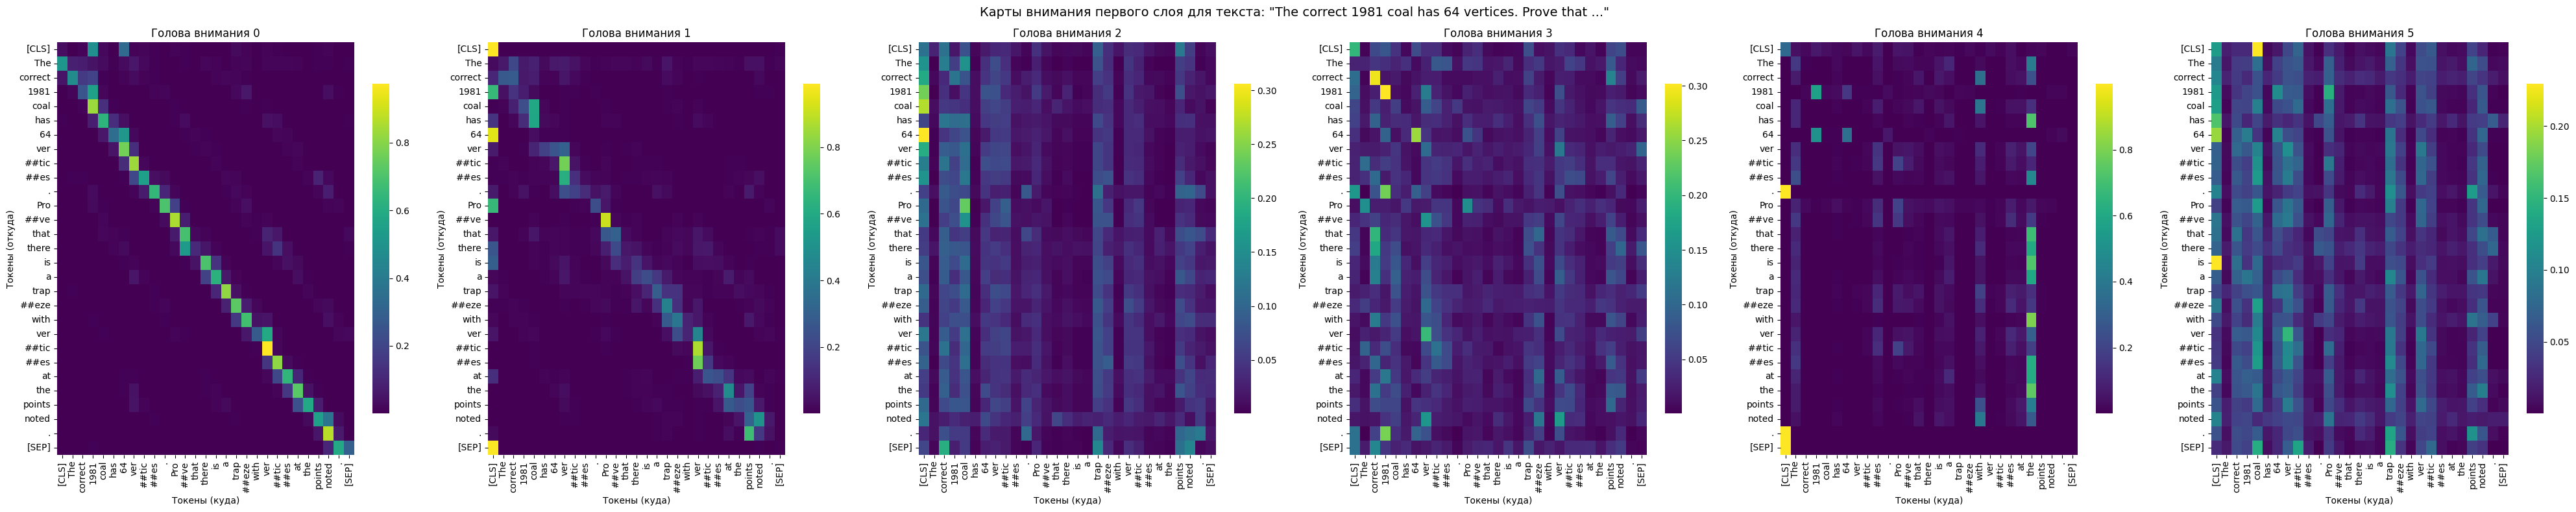

In [43]:
draw_first_layer_attention_maps([0, 1, 2, 3,4,5], 'The correct 1981 coal has 64 vertices. Prove that there is a trapeze with vertices at the points noted.' ,rubert_tiny_full_finetuned)

# Получили что слои внимания отвечают за свои блок. Есть те которые отвечют за полное сопоставление токена токену, а есть которые отвечают за концы предложения